# **🐌 Twitter Comments Sentiment Analysis - BERT**
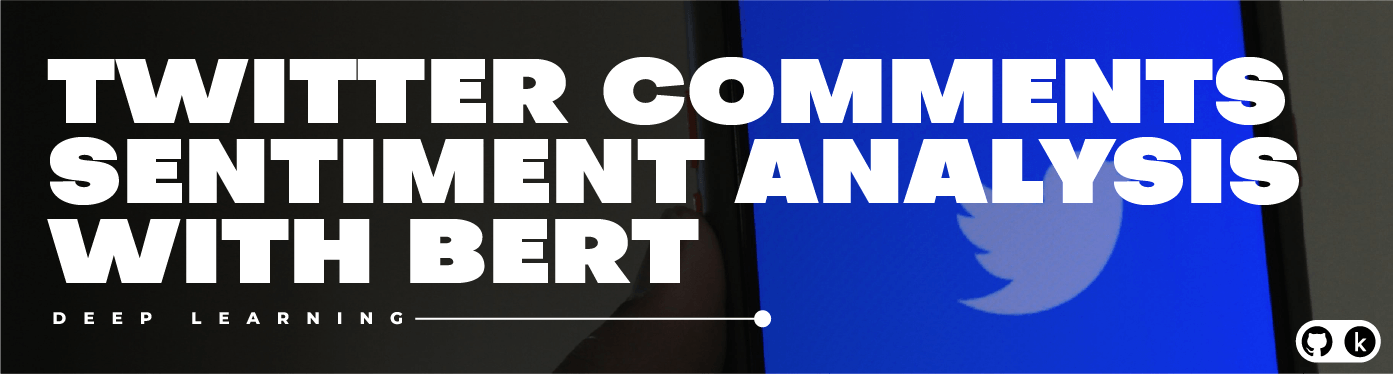
Twitter comments sentiment analysis is a crucial tool in today's digital age, where social media plays a central role in shaping public opinion and influencing decisions. By analyzing the sentiments expressed in tweets, businesses, governments, and organizations can gauge public mood, identify trends, and respond to customer feedback or emerging issues in real time. Traditional methods of sentiment analysis can be slow and inaccurate, but with the advent of advanced models like BERT (Bidirectional Encoder Representations from Transformers), the process has become significantly faster and more accurate. BERT's ability to understand context and nuances in language, combined with its efficiency in processing large datasets, allows for real-time analysis of Twitter comments, enabling quicker and more informed decision-making.

# **Importing Data**

In [10]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        src = os.path.join(dirname, filename)

In [11]:
import numpy as np
import pandas as pd

# set column names
columns = ['target', 'ids', 'date', 'flag', 'user', 'text']

# set encoding
enc = "ISO-8859-1"

# read csv file
df = pd.read_csv(src, encoding = enc, names = columns)
df.head()

target         ids                          date      flag  \
0       0  1467810369  Mon Apr 06 22:19:45 PDT 2009  NO_QUERY   
1       0  1467810672  Mon Apr 06 22:19:49 PDT 2009  NO_QUERY   
2       0  1467810917  Mon Apr 06 22:19:53 PDT 2009  NO_QUERY   
3       0  1467811184  Mon Apr 06 22:19:57 PDT 2009  NO_QUERY   
4       0  1467811193  Mon Apr 06 22:19:57 PDT 2009  NO_QUERY   

              user                                               text  
0  _TheSpecialOne_  @switchfoot http://twitpic.com/2y1zl - Awww, t...  
1    scotthamilton  is upset that he can't update his Facebook by ...  
2         mattycus  @Kenichan I dived many times for the ball. Man...  
3          ElleCTF    my whole body feels itchy and like its on fire   
4           Karoli  @nationwideclass no, it's not behaving at all....

# **Preprocessing Data**

In [12]:
# getting data info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600000 entries, 0 to 1599999
Data columns (total 6 columns):
 #   Column  Non-Null Count    Dtype 
---  ------  --------------    ----- 
 0   target  1600000 non-null  int64 
 1   ids     1600000 non-null  int64 
 2   date    1600000 non-null  object
 3   flag    1600000 non-null  object
 4   user    1600000 non-null  object
 5   text    1600000 non-null  object
dtypes: int64(2), object(4)
memory usage: 73.2+ MB


In [13]:
# getting data shape
df.shape

(1600000, 6)

In [14]:
# taking a subset of the entire dataset for resource constraints
df = df[['text']].head(10000)
df.head()

text
0  @switchfoot http://twitpic.com/2y1zl - Awww, t...
1  is upset that he can't update his Facebook by ...
2  @Kenichan I dived many times for the ball. Man...
3    my whole body feels itchy and like its on fire 
4  @nationwideclass no, it's not behaving at all....

In [15]:
import re
import string
from bs4 import BeautifulSoup
from nltk.corpus import stopwords

def clean_text(text):
    
    # removing HTML tags
    text = BeautifulSoup(text, "html.parser").get_text()

    # converting text to lowercase
    text = text.lower()
    
    # remove URLs (http, https, www)
    text = re.sub(r'http\S+|www\S+', '', text)

    # removing punctuation
    text = re.sub(f"[{re.escape(string.punctuation)}]", "", text)

    # removing stopwords
    stop_words = set(stopwords.words('english'))
    text = " ".join([word for word in text.split() if word not in stop_words])

    # removing unnecessary whitespaces
    text = re.sub(r'\s+', ' ', text).strip()

    return text

In [16]:
df['text'] = df['text'].apply(lambda x: clean_text(x))
df.head()

/tmp/ipykernel_34/2267488199.py:9: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  text = BeautifulSoup(text, "html.parser").get_text()


text
0  switchfoot thats bummer shoulda got david carr...
1  upset cant update facebook texting might cry r...
2  kenichan dived many times ball managed save 50...
3                   whole body feels itchy like fire
4           nationwideclass behaving im mad cant see

## **Checking GPU Availability**

In [17]:
import torch

print(torch.cuda.is_available())
print(torch.cuda.current_device())
print(torch.cuda.get_device_name(0))

True
0
Tesla P100-PCIE-16GB


## **Importing BERT Model**

In [18]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

# Set GPU when available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load model directly
tokenizer = AutoTokenizer.from_pretrained("nlptown/bert-base-multilingual-uncased-sentiment")
model = AutoModelForSequenceClassification.from_pretrained("nlptown/bert-base-multilingual-uncased-sentiment")

tokenizer_config.json:   0%|          | 0.00/39.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/953 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/872k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/669M [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


## **Transfering data to GPU**

In [19]:
# Move the model to the appropriate device
model.to(device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(105879, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1

## **Defining function to predict sentiment**

In [20]:
def sentiment_score(review):
    
    # tokenize the input and move the tokens to the correct device (GPU or CPU)
    tokens = tokenizer.encode(review, return_tensors='pt').to(device)
    
    # perform the model prediction
    result = model(tokens)
    
    # return the sentiment score
    return int(torch.argmax(result.logits)) + 1

In [21]:
# make predictions
df['sentiment'] = df['text'].apply(lambda x: sentiment_score(x[:512]))
df.head()

text  sentiment
0  switchfoot thats bummer shoulda got david carr...          1
1  upset cant update facebook texting might cry r...          1
2  kenichan dived many times ball managed save 50...          1
3                   whole body feels itchy like fire          2
4           nationwideclass behaving im mad cant see          5

# **THANK YOU**
---